In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from skimage import io
from skimage.morphology import disk, square, erosion, binary_closing
import skimage.segmentation as seg
import skimage.filters as filters
#import skimage.filters.unsharp_mask as unsharp_mask
#import skimage.filters.threshold_local as threshold_local
import skimage.draw as draw
import skimage.color as color

In [7]:
def img_show(image, nrows=1, ncols=1, cmap='gray', figsize = (8,8)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

(13000, 26000)

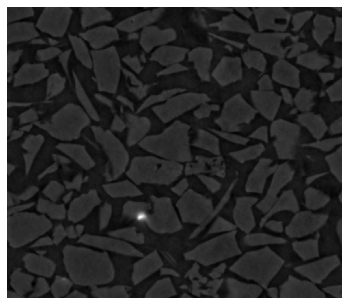

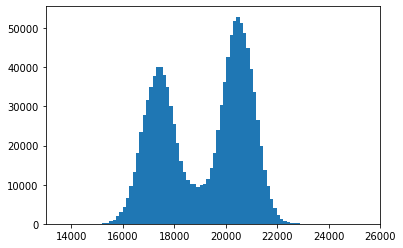

In [8]:
image = io.imread('Dec02Scan/With_PC/SlicesX/slice00404.tif')
img_show(image,figsize = (6,6))
fig, ax = plt.subplots(1,1)
Range = [13000,26000]
ax.hist(image.ravel(), bins = 100, range = Range)
ax.set_xlim(Range)

In [362]:
def hole_dust_removal(image, size_dust = 25, size_hole = 25):
    #this function removes the hole and dust noise below the given size
    #consider the diagonal connectivity
    #image should be binary 0 or 1: 1 is foreground and 0 is background
    s = np.array([[1,1,1],[1,1,1],[1,1,1]])
    #remove the dusts from backgroundground
    labeled_array, num_features = scipy.ndimage.measurements.label(image, structure = s)
    for i in range(num_features):
        mask = (labeled_array == (i+1))
        feature_size = np.sum((mask).astype(int))
        #if feature_size<=size:
        #    print(feature_size)
        if feature_size <= size_dust:
            image[mask] = 0
            
    #remove the tiny holes from the foreground
    img_inv = np.abs(image-1) 
    labeled_array, num_features = scipy.ndimage.measurements.label(img_inv, structure = s)
    for i in range(num_features):
        mask = (labeled_array == (i+1))
        feature_size = np.sum((mask).astype(int))
        if feature_size <= size_hole:
            image[mask] = 1
            
    return image

In [363]:
def substract_edge(image, edge):
    #both image and edge are binary images; 0 is background and 1 is foreground
    m,n = image.shape
    image = image - edge
    for i in range(m):
        for j in range(n):
            if image[i,j] <0:
                image[i,j] = 0
    return image

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x16d4de2e8>)

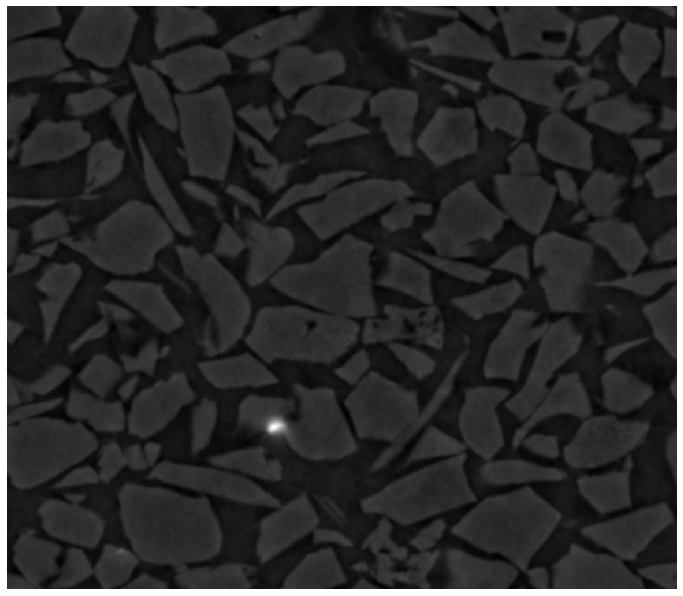

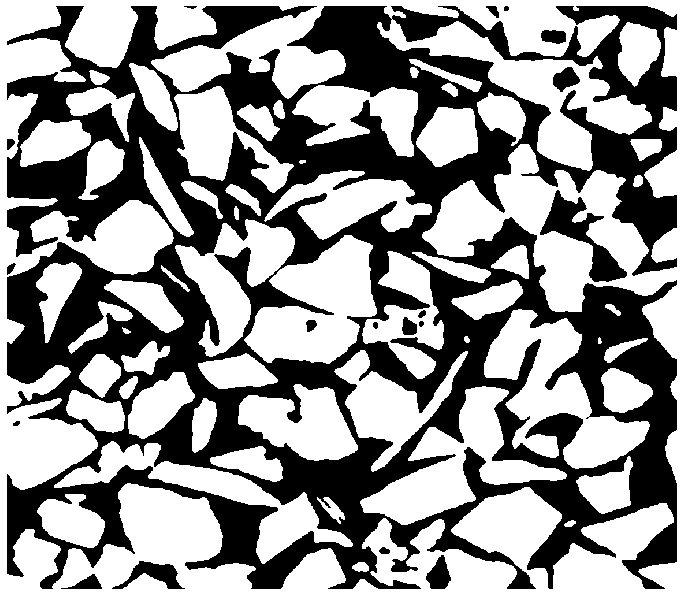

In [373]:
#Apply different filters
img_median = filters.median(image, disk(3))
img_sharp = filters.unsharp_mask(img_median, radius = 3, amount = 1)

img_opt = img_median

#use otsu threshold
img_thres_otsu = filters.threshold_otsu(img_opt, nbins=256)

#do the segmentation
segmentation = (img_opt>img_thres_otsu).astype('int')

#remove the holes
segmentation = hole_dust_removal(segmentation, size_dust = 64, size_hole = 64)

img_show(image, figsize = (12,12))
img_show(segmentation, figsize = (12,12))

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x183b2acf8>)

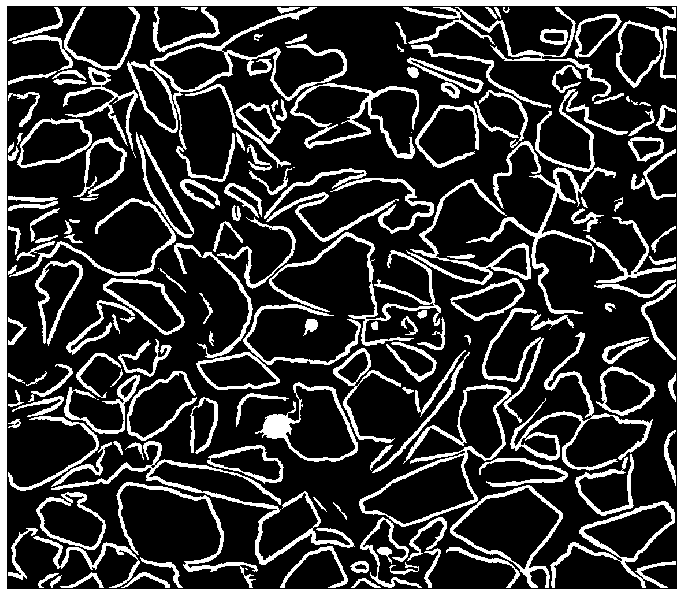

In [376]:
img_opt = img_median
edges = filters.sobel(img_opt)
thres_edges = filters.threshold_local(edges, block_size = 601)
edges = (edges>1.9*thres_edges).astype('int')
edges = hole_dust_removal(edges, size_dust = 64, size_hole = 64)
#substract the boundary
segmentation = substract_edge(segmentation, edges)
img_show(edges, figsize = (12,12))



(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19e5f2f60>)

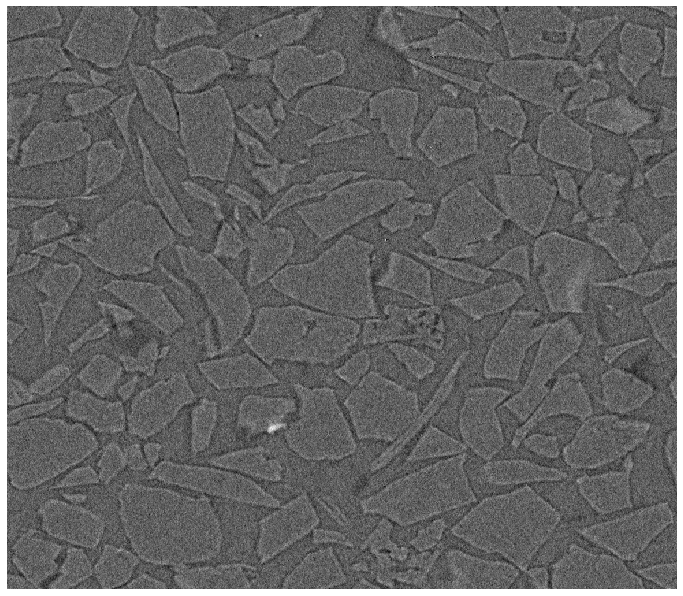

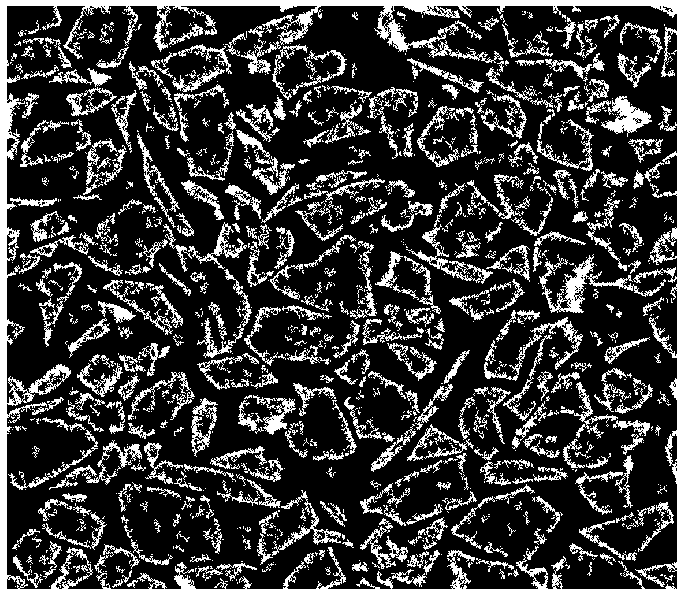

In [392]:
img_PC = io.imread('Dec02Scan/Without_PC/SlicesX/slice00404.tif')
#img_show(img_PC,figsize = (6,6))
PC_median = filters.median(img_PC, disk(3))

img_opt = img_PC
img_show(img_opt,figsize = (12,12))

PC_thres = filters.threshold_local(img_opt, block_size = 601,offset = 0)
boundary = (img_opt>1.02*PC_thres).astype('int')
boundary = hole_dust_removal(boundary, size_dust = 64, size_hole = 64)
img_show(boundary, figsize = (12,12))


Text(0.5, 1.0, 'Sharped')

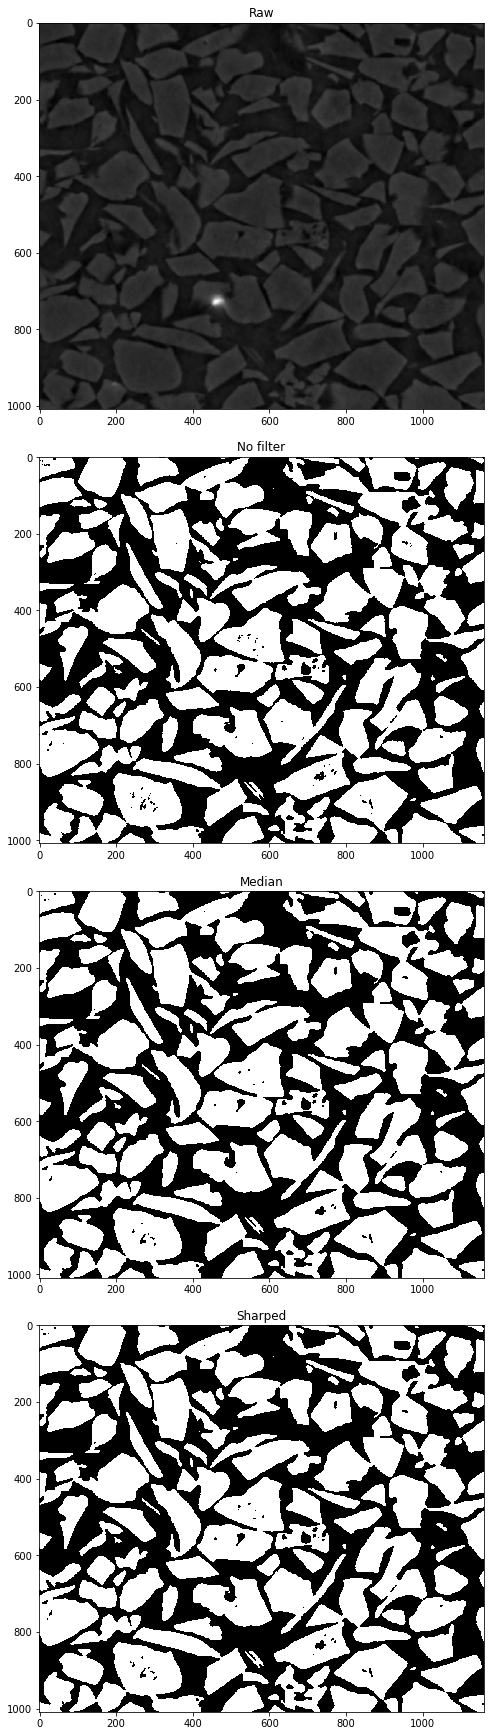

In [372]:
#try the local threshold methods
img_median = filters.median(image, disk(3))

img_no_filter = filters.threshold_local(image, block_size = 501,offset = 0)
seg_no_filter = 255*(image>img_no_filter).astype('int')
#img_show(seg_no_filter)

median_thres_local = filters.threshold_local(img_median, block_size = 501,offset = 0)
seg_median = 255*(img_median>median_thres_local).astype('int')
#img_show(seg_median)

img_sharp = filters.unsharp_mask(img_median, radius=1, amount=1)
sharp_thres_local = filters.threshold_local(img_sharp, block_size = 501,offset = 0)
seg_sharp = 255*(img_sharp>sharp_thres_local).astype('int')
#img_show(seg_sharp)



fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize = (24,24))
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title('Raw')
axs[1].imshow(seg_no_filter, cmap = 'gray')
axs[1].set_title('No filter')
axs[2].imshow(seg_median, cmap = 'gray')
axs[2].set_title('Median')
axs[3].imshow(seg_sharp, cmap = 'gray')
axs[3].set_title('Sharped')


In [ ]:
# this is the main function for image processing using otsu threshold
image_number = 1034;#1034 for Dec02Scan
for i in range(image_number):
    if i<10:
        filename = 'slice0'+'000'+ str(i)
    elif i>=10 and i<100:
        filename = 'slice0'+'00'+ str(i)
    elif i>=100 and i<1000:
        filename = 'slice0'+'0'+ str(i)
    else:
        filename = 'slice0'+ str(i)
    #read the image
    image = io.imread('Dec02Scan/With_PC/SlicesX/' + filename + '.tif')
    
    #apply the median filter
    img_median = filters.median(image, disk(3))
    
    #sharp the image
    img_sharp = filters.unsharp_mask(img_median, radius=3, amount=1)
    
    #do the segmentation
    img_thres_otsu = filters.threshold_otsu(img_sharp,nbins=256)
    segmentation = (img_sharp>img_thres_otsu).astype('int')
    
    #remove the dusts and holes
    segmentation = hole_dust_removal(segmentation, size_dust = 64, size_hole = 64)
    
    #save the segmented image
    io.imsave('Segmented/Dec02Scan_OTSU/' + filename + '.tiff', segmentation)
